In this notebook we train a multiclass cancer type classifier for GDC data and for PDX data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
assert sys.version_info >= (3, 5)

from pathlib import Path
from pprint import pprint
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from typing import List, Optional, Union

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential, Model

import matplotlib.pyplot as plt

# Seed
seed = 0
np.random.seed(seed)

fdir = Path.cwd()
print(fdir)
sys.path.append(str(fdir/'../src'))
from config import cfg

/vol/ml/apartin/projects/pdx-histo/nbs


In [2]:
datadir = fdir/'../data/raw'
rna = pd.read_csv(datadir/'combined_rnaseq_data_lincs1000', sep='\t')
meta = pd.read_csv(datadir/'combined_metadata_2018May.txt', sep='\t')

rna = rna.rename(columns={c: 'ge_'+str(c) for c in rna.columns[1:]})  # add ge_ prefix
rna.insert(loc=1, column='src', value=rna.Sample.map(lambda x: x.split('.')[0]), allow_duplicates=True)

meta = meta.rename(columns={'sample_name': 'Sample',
                        'dataset': 'src',
                        'tumor_site_from_data_src': 'csite_src',
                        'tumor_type_from_data_src': 'ctype_src',
                        'simplified_tumor_site': 'csite',
                        'simplified_tumor_type': 'ctype'})
meta = meta.drop(columns=['copy_flag'])
print(rna.shape)
print(meta.shape)

# PDX
pdx_rna = rna[rna.src.isin(['NCIPDM'])].reset_index(drop=True)
pdx_meta = meta[meta.src.isin(['NCIPDM'])].reset_index(drop=True)

# GDC
gdc_rna = rna[rna.src.isin(['GDC'])].reset_index(drop=True)
gdc_meta = meta[meta.src.isin(['GDC'])].reset_index(drop=True)
gdc_meta.insert(loc=2, column='ctype_gdc', value=rna.Sample.map(lambda x: x.split('.')[1]), allow_duplicates=True)
                 
print(gdc_rna.shape)
print(gdc_meta.shape)

display(gdc_meta.iloc[:2, :10])
display(gdc_meta.iloc[:2, :10])

(15196, 944)
(15196, 19)
(11081, 944)
(11081, 20)


,Sample,src,ctype_gdc,patient_id,specimen_id,sample_id,core_str,csite_src,ctype_src,csite
0,GDC.ADR_ACC.TCGA_OR_A5J1_08081.p,GDC,22RV1,TCGA-OR-A5J1,NaN,01A,TCGA-OR-A5J1,adrenal gland,Adrenocortical Carcinoma,endocrine and neuroendocrine
1,GDC.ADR_ACC.TCGA_OR_A5J2_10193.p,GDC,2313287,TCGA-OR-A5J2,NaN,01A,TCGA-OR-A5J2,adrenal gland,Adrenocortical Carcinoma,endocrine and neuroendocrine


,Sample,src,ctype_gdc,patient_id,specimen_id,sample_id,core_str,csite_src,ctype_src,csite
0,GDC.ADR_ACC.TCGA_OR_A5J1_08081.p,GDC,22RV1,TCGA-OR-A5J1,NaN,01A,TCGA-OR-A5J1,adrenal gland,Adrenocortical Carcinoma,endocrine and neuroendocrine
1,GDC.ADR_ACC.TCGA_OR_A5J2_10193.p,GDC,2313287,TCGA-OR-A5J2,NaN,01A,TCGA-OR-A5J2,adrenal gland,Adrenocortical Carcinoma,endocrine and neuroendocrine


# GDC

In [3]:
display(gdc_meta.ctype_gdc.value_counts()[:10])
# mm.ctype_gdc.value_counts().values == mm.ctype_src.value_counts().values

BR_BRCA    1222
RE_KIRC     608
LC_LUAD     594
LC_LUSC     551
PR_PRAD     548
HN_HNSC     546
CNS_LGG     529
CO_COAD     518
BL_BLCA     433
LI_LIHC     424
Name: ctype_gdc, dtype: int64

In [4]:
# Create balanced dataset on ctype
n_classes = 10
cls_label = 'ctype_gdc'
min_count = gdc_meta[cls_label].value_counts().iloc[n_classes-1]

dfs = []
for ctype in gdc_meta[cls_label].value_counts().index[:n_classes]:
    df = gdc_meta[gdc_meta[cls_label].isin([ctype])]
    df = df.sample(n=min_count, random_state=seed)
    dfs.append(df)

gdc_meta = pd.concat(dfs, axis=0).sort_values('Sample', ascending=True).reset_index(drop=True)
gdc_rna = gdc_rna[gdc_rna.Sample.isin(gdc_meta.Sample.values)].sort_values('Sample', ascending=True).reset_index(drop=True)

del dfs, df

In [9]:
# y_encoding = 'onehot'
y_encoding = 'label'

# Onehot encoding
ydata = gdc_meta[cls_label].values
# y_onehot = pd.get_dummies(ydata_label)
y_onehot = pd.get_dummies(ydata)
ydata_label = np.argmax(y_onehot.values, axis=1)

# Scale RNA
x_scaler = StandardScaler()
xdata = gdc_rna.iloc[:, 2:]
cols = xdata.columns
xdata = pd.DataFrame(x_scaler.fit_transform(xdata), columns=cols, dtype=np.float32)

# Split
tr_ids, te_ids = train_test_split(range(xdata.shape[0]), test_size=0.2, random_state=seed, stratify=ydata)
xtr = xdata.iloc[tr_ids, :].reset_index(drop=True)
xte = xdata.iloc[te_ids, :].reset_index(drop=True)

if y_encoding == 'onehot':
    ytr = y_onehot.iloc[tr_ids, :].reset_index(drop=True)
    yte = y_onehot.iloc[te_ids, :].reset_index(drop=True)
    loss = losses.CategoricalCrossentropy()
elif y_encoding == 'label':
    ytr = ydata_label[tr_ids]
    yte = ydata_label[te_ids]
    loss = losses.SparseCategoricalCrossentropy()
else:
    raise ValueError(f'Unknown value for y_encoding ({y_encoding}).')
    
ytr_label = ydata_label[tr_ids]
yte_label = ydata_label[te_ids]

# display(mm.iloc[tr_ids]['ctype_gdc'].value_counts())
# display(mm.iloc[te_ids]['ctype_gdc'].value_counts())

# Model
inputs = Input(shape=(xtr.shape[1],), name='rna_input')
# x = Dense(4, activation=tf.nn.relu)(inputs)
x = Dense(256, activation=tf.nn.relu)(inputs)
x = Dropout(0.1)(x)
outputs = Dense(n_classes, activation=tf.nn.softmax, name='ctype')(x)

gdc_model = Model(inputs=[inputs], outputs=[outputs])

gdc_model.compile(loss=loss,
                  optimizer=optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

gdc_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rna_input (InputLayer)       [(None, 942)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               241408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
ctype (Dense)                (None, 10)                2570      
Total params: 243,978
Trainable params: 243,978
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Train
epochs = 4
batch_size = 32
history = gdc_model.fit(xtr, ytr, epochs=epochs, batch_size=batch_size, validation_data=(xte, yte))

Epoch 1/4
106/106 [==============================] - 0s 4ms/step - loss: 1.1816 - accuracy: 0.6459 - val_loss: 0.5905 - val_accuracy: 0.8302
Epoch 2/4
106/106 [==============================] - 0s 3ms/step - loss: 0.5145 - accuracy: 0.8502 - val_loss: 0.4426 - val_accuracy: 0.8597
Epoch 3/4
106/106 [==============================] - 0s 3ms/step - loss: 0.3864 - accuracy: 0.8815 - val_loss: 0.3796 - val_accuracy: 0.8691
Epoch 4/4
106/106 [==============================] - 0s 3ms/step - loss: 0.3219 - accuracy: 0.8924 - val_loss: 0.3419 - val_accuracy: 0.8856


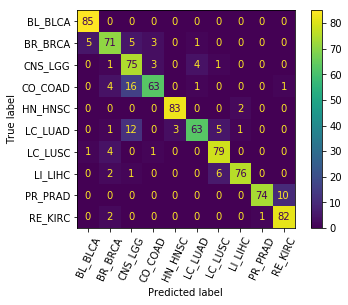

In [11]:
yte_prd = gdc_model.predict(xte)
yte_prd_label = np.argmax(yte_prd, axis=1)
# yte_true_label = np.argmax(yte.values, axis=1)

cnf_mtrx = confusion_matrix(yte_label, yte_prd_label)
disp = ConfusionMatrixDisplay(cnf_mtrx, display_labels=list(y_onehot.columns))
disp.plot(xticks_rotation=65);

# PDX

In [13]:
# Create balanced dataset on ctype
n_classes = 2
cls_label = 'ctype'
min_count = pdx_meta[cls_label].value_counts().iloc[n_classes-1]

dfs = []
for ctype in pdx_meta[cls_label].value_counts().index[:n_classes]:
    df = pdx_meta[pdx_meta[cls_label].isin([ctype])]
    df = df.sample(n=min_count, random_state=seed)
    dfs.append(df)

pdx_meta = pd.concat(dfs, axis=0).sort_values('Sample', ascending=True).reset_index(drop=True)
pdx_rna = pdx_rna[pdx_rna.Sample.isin(pdx_meta.Sample.values)].sort_values('Sample', ascending=True).reset_index(drop=True)

del dfs, df

print(pdx_meta.shape)
print(pdx_rna.shape)
pdx_meta.ctype.value_counts()

(510, 19)
(510, 944)


squamous                      255
digestive/gastrointestinal    255
Name: ctype, dtype: int64

In [14]:
# y_encoding = 'onehot'
y_encoding = 'label'

# Onehot encoding
ydata = pdx_meta[cls_label].values
# y_onehot = pd.get_dummies(ydata_label)
y_onehot = pd.get_dummies(ydata)
ydata_label = np.argmax(y_onehot.values, axis=1)

# Scale RNA
x_scaler = StandardScaler()
xdata = pdx_rna.iloc[:, 2:]
cols = xdata.columns
xdata = pd.DataFrame(x_scaler.fit_transform(xdata), columns=cols, dtype=np.float32)

# Split
tr_ids, te_ids = train_test_split(range(xdata.shape[0]), test_size=0.2, random_state=seed, stratify=ydata)
xtr = xdata.iloc[tr_ids, :].reset_index(drop=True)
xte = xdata.iloc[te_ids, :].reset_index(drop=True)

if y_encoding == 'onehot':
    ytr = y_onehot.iloc[tr_ids, :].reset_index(drop=True)
    yte = y_onehot.iloc[te_ids, :].reset_index(drop=True)
    loss = losses.CategoricalCrossentropy()
elif y_encoding == 'label':
    ytr = ydata_label[tr_ids]
    yte = ydata_label[te_ids]
    loss = losses.SparseCategoricalCrossentropy()
else:
    raise ValueError(f'Unknown value for y_encoding ({y_encoding}).')
    
ytr_label = ydata_label[tr_ids]
yte_label = ydata_label[te_ids]

# Model
inputs = Input(shape=(xtr.shape[1],), name='rna_input')
# x = Dense(4, activation=tf.nn.relu)(inputs)
x = Dense(256, activation=tf.nn.relu)(inputs)
x = Dropout(0.1)(x)
outputs = Dense(n_classes, activation=tf.nn.softmax, name='ctype')(x)

gdc_model = Model(inputs=[inputs], outputs=[outputs])

gdc_model.compile(loss=loss,
                  optimizer=optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

gdc_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rna_input (InputLayer)       [(None, 942)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               241408    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
ctype (Dense)                (None, 2)                 514       
Total params: 241,922
Trainable params: 241,922
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Train
epochs = 2
batch_size = 32
history = gdc_model.fit(xtr, ytr, epochs=epochs, batch_size=batch_size, validation_data=(xte, yte))

Epoch 1/2
13/13 [==============================] - 0s 11ms/step - loss: 0.4124 - accuracy: 0.8211 - val_loss: 0.1788 - val_accuracy: 0.9412
Epoch 2/2
13/13 [==============================] - 0s 4ms/step - loss: 0.1509 - accuracy: 0.9559 - val_loss: 0.0903 - val_accuracy: 0.9608


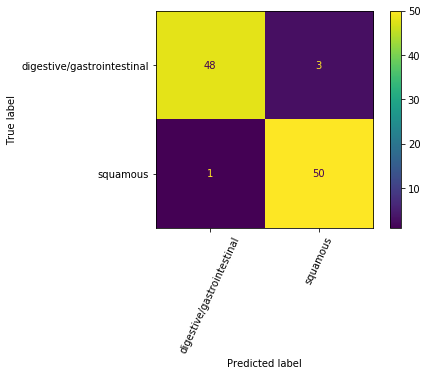

In [16]:
yte_prd = gdc_model.predict(xte)
yte_prd_label = np.argmax(yte_prd, axis=1)
# yte_true_label = np.argmax(yte.values, axis=1)

cnf_mtrx = confusion_matrix(yte_label, yte_prd_label)
disp = ConfusionMatrixDisplay(cnf_mtrx, display_labels=list(y_onehot.columns))
disp.plot(xticks_rotation=65);